In [1]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
from eofs.standard import Eof

In [2]:
## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [3]:
#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'
stash_nox = 'm01s50i081'

In [4]:
#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def moving_average(x, months):
    return np.convolve(x, np.ones(months), 'valid') / months

In [5]:
#define constants
n_a = 6.02e23
oh_mr = 17

In [6]:
# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [7]:
#### Fetch data
oh_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_oh_PI.nc',chunks={'time':50})
oh_949 = oh_data_949.variables[stash_oh][:]

lat = oh_data_949.latitude[:]
lon = oh_data_949.longitude[:]
time = oh_data_949.time[:]

# trop_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_trop_mask_PI.nc',chunks={'time':24})

airmass_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc',chunks={'time':24})
airmass_949 = airmass_data_949.variables[stash_mass]

In [8]:
# create then resample a tropospheric mask for monthly data
o3 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_o3_PI_run.nc',chunks={'time':24})
o3['mask'] = xr.ones_like(o3[stash_o3])
o3['mask'] = o3.mask.where(o3[stash_o3]<7.544e-8, other =0.)
o3['mask'] = o3.mask*airmass_949

In [9]:
# Calculate tropospheric mean OH
oh_trop = dd.array.average(oh_949,weights=o3.mask,axis=1)
oh_gm = dd.array.average(oh_949,weights=o3.mask,axis=(1,2,3))

In [10]:
# Convert to % OH anomaly
oh_mean = dd.array.average(oh_trop,axis=0)
oh_anom = np.multiply(np.divide(oh_trop - oh_mean,oh_mean),100)

In [11]:
# fig = plt.figure(dpi=300)
# ax = plt.axes()

# # ax.set_xlim(0,50000)

# ax.plot(oh_data_949.time,oh_gm)

Create EOF for OH data

In [11]:
# define weights then create a grid of scaled values with sqrt(cos(latitude))
weight_lat = np.abs(np.cos(lat))
weight_grid_lonlat = np.tile(weight_lat,(192,1))
w_use = weight_grid_lonlat.transpose()

# for some reason doesn't like to do the analysis on the dask array, gives an error about missing values and wrong size matrices, but computing into a numpy array works fine
oh_comp = oh_anom.compute()

# eof analysis
solver = Eof(oh_comp,weights=w_use)

In [12]:
eofs = solver.eofsAsCorrelation(neofs=5)
eofs_real = solver.eofs(neofs=5)
pcs = solver.pcs(npcs=5,pcscaling=1)

In [14]:
eofs_out = xr.DataArray(data=eofs,
                           name='EOFs',
                           dims=['number','latitude','longitude'],
                           coords=dict(
                               latitude = (["latitude"], lat.data),
                               longitude = (["longitude"], lon.data)
                           )
                          )

reofs_out = xr.DataArray(data=eofs_real,
                           name='EOFs',
                           dims=["number","latitude","longitude"],
                           coords=dict(
                               latitude = (["latitude"], lat.data),
                               longitude = (["longitude"], lon.data)
                           )
                          )

pcs_out = xr.DataArray(data=pcs,
                           name='EOFs',
                           dims=["time",'number'],
                           coords=dict(
                               number = (["number"], np.arange(0,5)),
                               time = (["time"], time.data)
                           )
                          )

In [15]:
pcs_out.to_netcdf('pc_949.nc')
eofs_out.to_netcdf('eofs_949.nc')
reofs_out.to_netcdf('reofs_949.nc')

Plotting of EOFs and associated PCs

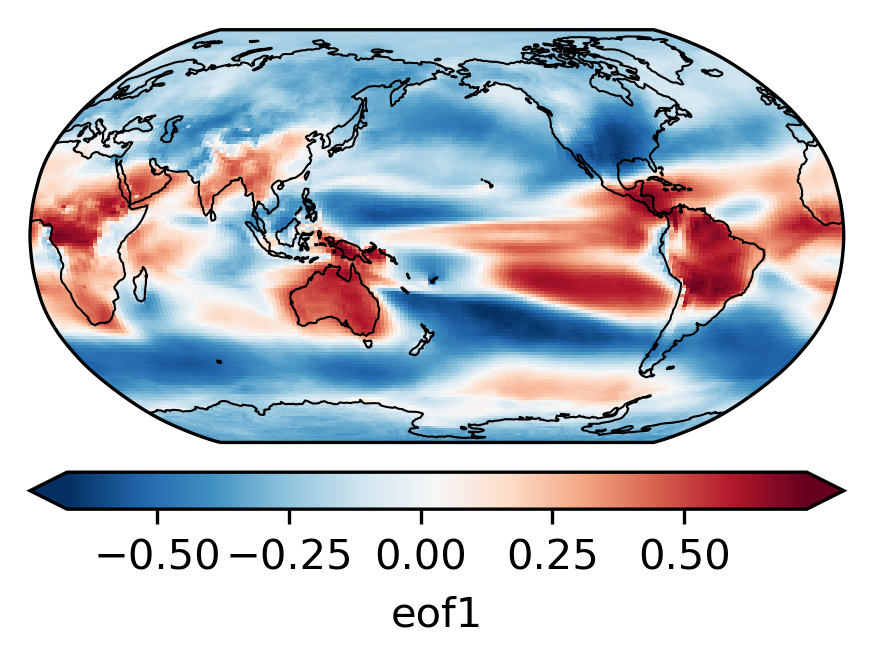

In [16]:
# show 1st eof on a map
fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

eof_cyclic, lon_plot = add_cyclic_point(eofs[0,:,:], coord=lon)   

plt.pcolormesh(lon_plot,lat,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0))#, vmin=-1, vmax=1)

plt.colorbar(label = 'eof1' ,orientation='horizontal',pad=0.05, extend='both')

In [13]:
# Correlate PC to input data to determine whether + or -
# Pearson correlation data, returns statistical as (r,p)

from scipy.stats.stats import pearsonr
stat = pearsonr(pcs[:,0],np.mean(oh_comp,axis=(1,2)))

print('Pearson correlation constant = ' + str(stat))
# slightly negative correlation suggests it may be best to take the negative

Pearson correlation constant = (-0.44574274272522935, 6.708818887094188e-20)


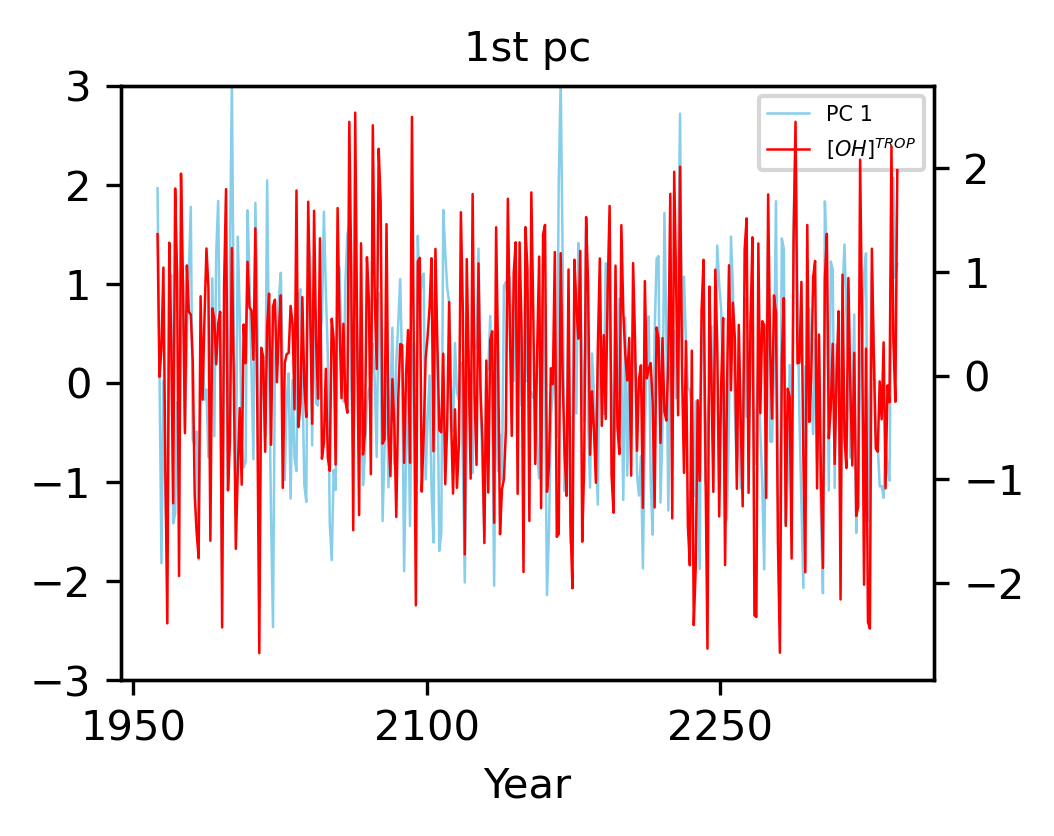

In [18]:
# Show PC is correct with 1yr period

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("", fontsize=8)
plt.title("1st pc", fontsize=10)
# ax.set_xlim(55000,65000)
ax.set_ylim(-3,3)

ax1 = ax.twinx()

line1, = ax1.plot(time,np.mean(oh_comp,axis=(1,2)), c='red',linewidth=0.6, label='$[OH]^{TROP}$')
line0, = ax.plot(time, -pcs[:,0], c='skyblue', linewidth=0.6, label='PC 1')

ax.legend(handles=[line0,line1],fontsize=5,loc ='upper right')

Fractions shows that the seasonal variation is responsible for ~79% of variability in the raw monthly OH data

In [14]:
fractions = solver.varianceFraction(neigs=5)
print(fractions)

[0.13501574 0.06964241 0.03852456 0.03490359 0.02839425]


Next need to deseasonalize the data in order to analyze non-seasonal temperature variation (No longer using deseasonalised data here so ignore this bit)

In [20]:
# Deseasonalise monthly oh data
# oh_ar = oh_data_949[stash_oh]
# oh_deseason = oh_ar.groupby('time.month') - oh_ar.groupby('time.month').mean('time') 

In [21]:
# oh_deseason_gm = dd.array.average(oh_deseason,weights=o3.mask,axis=(1,2,3))

In [22]:
# Plot deseasonalised

# fig = plt.figure(dpi=150)
# ax = plt.axes()

# ax.plot(oh_deseason.time,oh_deseason_gm)

Create Nino3.4 data required

In [15]:
## Plot temperature in NINO3.4

temp_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_temp_apm_1960_2340_PI.nc')
temp_949 = temp_data_949.surface_temperature
lat = temp_data_949.latitude
lon = temp_data_949.longitude
time_949 = temp_data_949.time

# apply nino3.4 mask to data
nino34_temp = temp_949.loc[:,-5:5,190:240]
nino_mean_949 = np.mean(nino34_temp,axis=(1,2))

# This solution takes more lines but preserves the rest of the array, which might be useful for something??? But selecting quickly using xarray .loc seems much easier
# temp_data_949['mask'] = xr.ones_like(temp_949)
# temp_data_949['mask'] = temp_data_949.mask.where(np.abs(temp_949.latitude)<5,other=0.) 
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude<240,other=0.)
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude>190,other=0.)
# enso_949 = ma.masked_where(temp_data_949.mask!=1,temp_949)
# nino_mean_949 = np.mean(enso_949,axis=(1,2))

## calculate 3 month mean for enso data

bl949_3monmean = moving_average(nino_mean_949,3)

bl949_30yrmean = moving_average(nino_mean_949,361)

temp_anomaly_bl949 = bl949_3monmean[179:-179] - bl949_30yrmean

dtime_949 = nc.date2num(time_949,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

In [24]:
# # Plot of temperature in the NINO3.4 region

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)
# ax = plt.axes()

# plt.xlabel("Year")
# ax.set_ylabel("temp", fontsize=8)
# plt.title("NINO3.4 temperature mean", fontsize=10)


# line0, = ax.plot(time_949, nino_mean_949, c='skyblue', linewidth=0.6)

In [25]:
# # Check NINO3.4 masking and temperature in region
# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0, globe=None))
# ax.set_global()
# ax.coastlines(linewidth=0.5)

# eof_cyclic, lon_plot = add_cyclic_point(np.mean(enso_949,axis=0), coord=lon)   

# plt.pcolormesh(lon_plot,lat,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=295, vmax=301)

# plt.colorbar(label = 'Temperature / K' ,orientation='horizontal',pad=0.05, extend='both')

Statistical and graphical analysis of OH PC and Nino3.4 temperature anomaly

In [21]:
# Convert PC to monthly data points, dtime_949 is monthly time point data, dtime is yearly time points
dtime = nc.date2num(time,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)
pcompare = np.interp(dtime_949,dtime,pcs[:,0])

In [49]:
### This method resamples the temperature anomaly data for comparison, but interpolating the PC data is probably easier
# # Calculate OH and PC correlation 
# # convert temp anomaly into yearly to find correlation
# res = np.empty

# for i in range(0,351):
#     av = np.mean(temp_anomaly_bl949[i*12:(i+1)*12])
#     res = np.append(res,av)

# # av = np.mean(temp_anomaly_bl949[:-1])
# # res = np.append(res,av)
# res = np.delete(res,0) # Deletes data left over from creation of empty array

# # Pearson correlation data, returns statistical as (r,p)
# pcsuse = pcs[:-28,0]

In [22]:
from scipy.stats.stats import pearsonr
stat = pearsonr(pcompare[180:-180],temp_anomaly_bl949)

print('Pearson correlation constant = ' + str(stat))

Pearson correlation constant = (0.48116113072012023, 5.316818962085652e-243)


Text(0.5, 1.0, 'u-bl949: PC 1 and NINO3.4 SST anomalies (r = -0.48)')

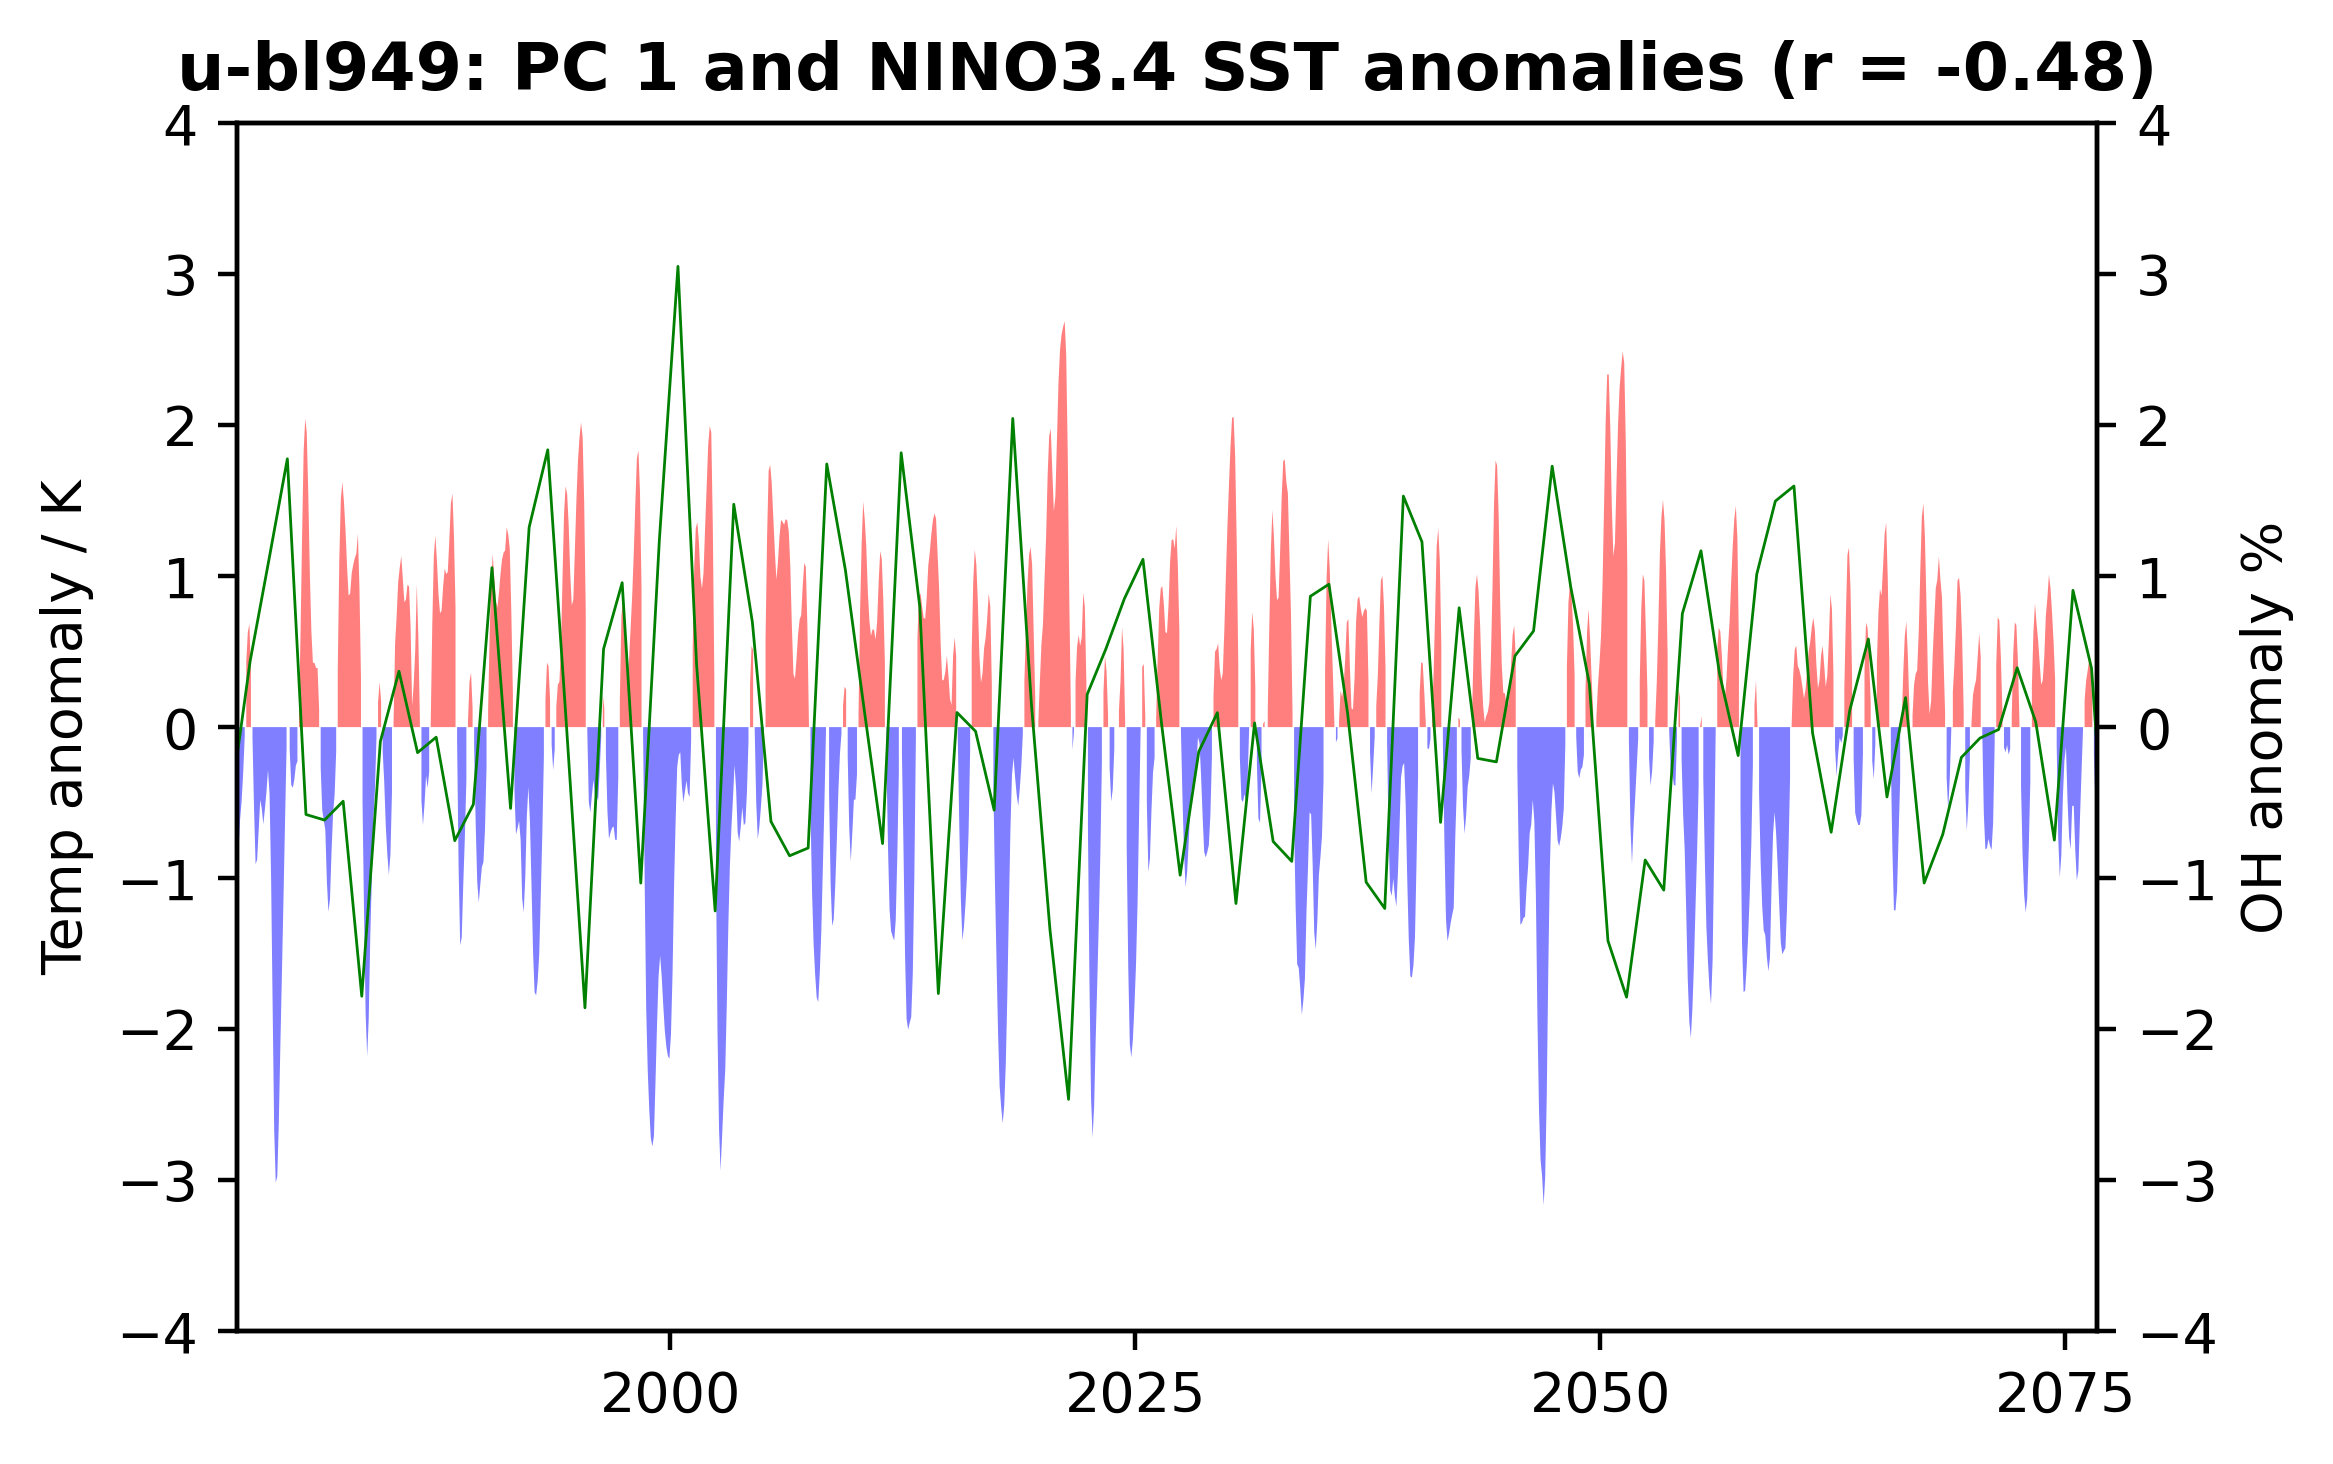

In [54]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=400)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
# p4, = ax.plot(Nino34_yr.time,Nino34_yr, label = 'SST anomaly yearly average', c = 'k', linewidth = 1)
p1 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly %', fontsize=10)
p3, = ax1.plot(time,-pcs[:,0], c='green', linewidth = 0.5,label='PC 1')
# p3, = ax1.plot(time,-pcsuse, c='green', linewidth = 1.5,label='PC 1')
# ax.plot(time[:-28],res,linewidth=0.5)


ax.set_ylim(-4,4)
ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[200],dtime_949[1400])

ax.set_ylabel('Temp anomaly / K')
# ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: PC 1 and NINO3.4 SST anomalies (r = -0.48)',fontweight='bold')

Text(0.5, 1.0, 'PC1 with ENSO state, r = -0.48')

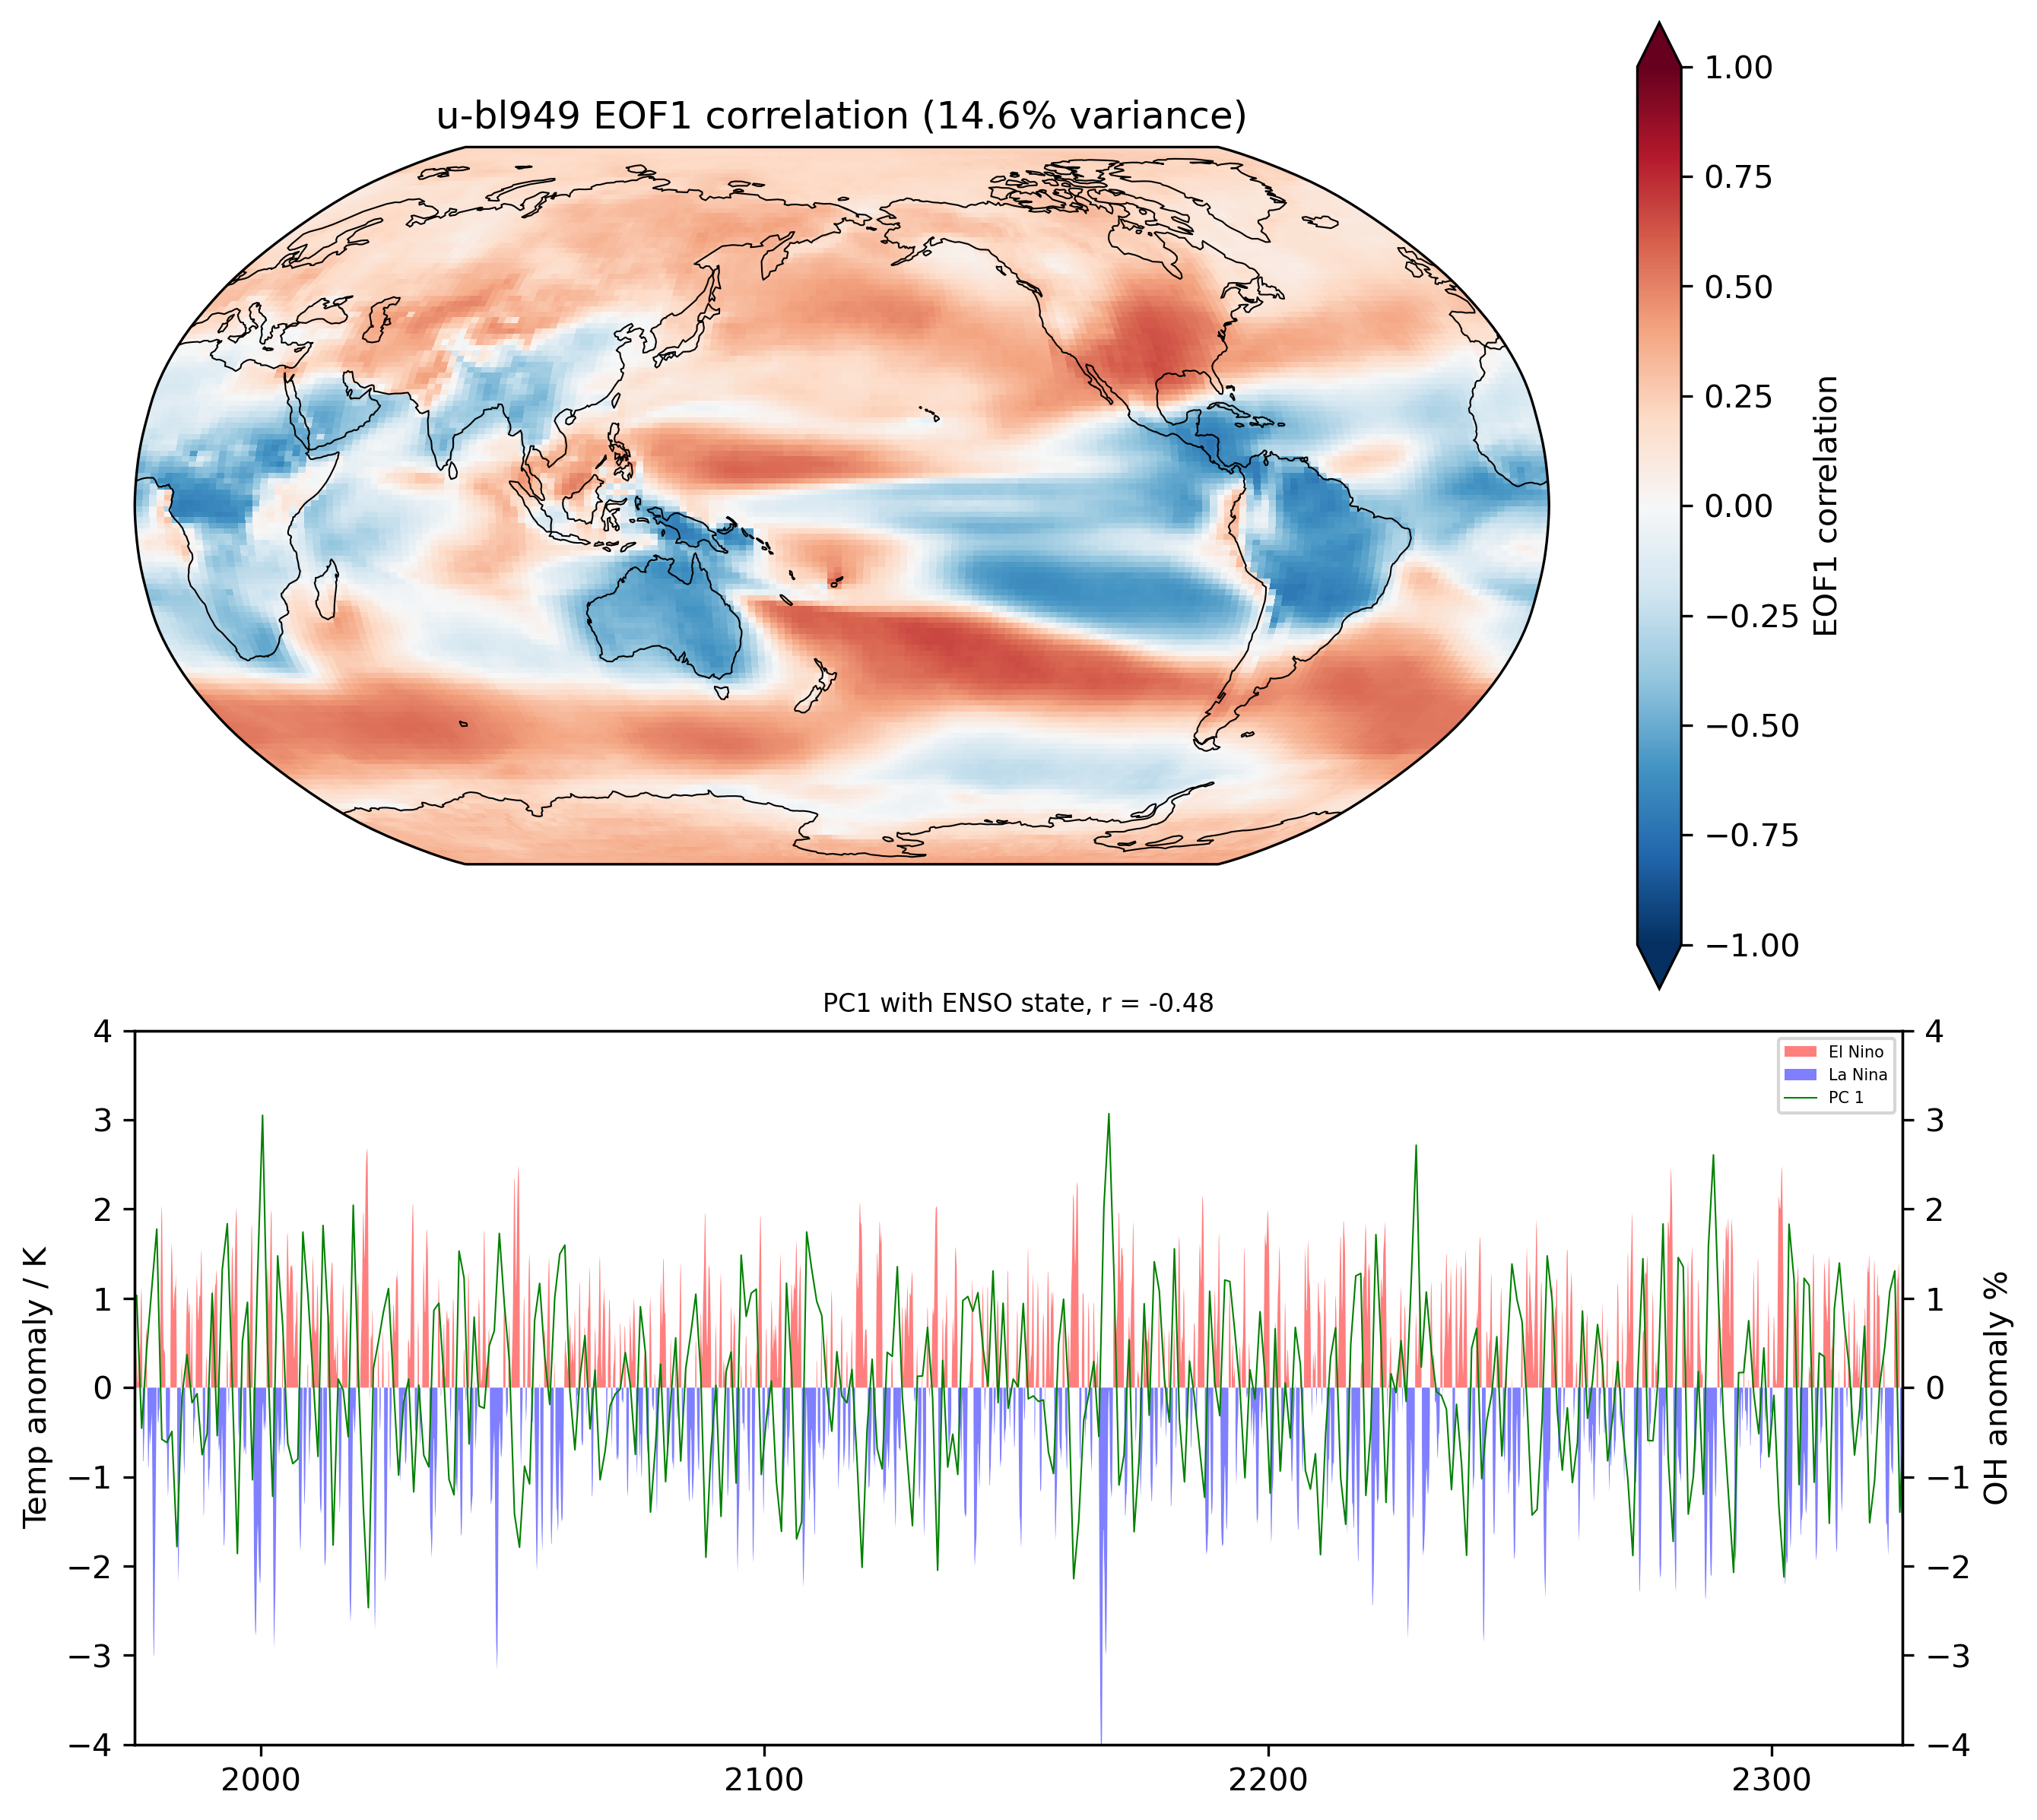

In [62]:
# Plot ENSO state with the PC solution

fig = plt.figure(figsize=(10,10),dpi=300)

ax = fig.add_subplot(7,1,(1,4),projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('u-bl949 EOF1 correlation (14.6% variance)')
ax.coastlines(linewidth=0.5)
bh_cyclic, lon_plot = add_cyclic_point(-eofs[0,:,:], coord=lon)   
c = ax.pcolormesh(lon_plot,lat,bh_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),vmin=-1,vmax=1)
cb = fig.colorbar(c, label= 'EOF1 correlation',extend='both',ax=ax)

ax1 = fig.add_subplot(7,1,(5,7))

p1 = ax1.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax1.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax2 = ax1.twinx(
ax2.set_ylabel('OH anomaly %', fontsize=10)
p3, = ax2.plot(time,-pcs[:,0], c='green', linewidth = 0.5,label='PC 1')

ax1.set_ylim(-4,4)
ax2.set_ylim(-4,4)
ax1.set_xlim(dtime_949[180],dtime_949[-180])

ax1.set_ylabel('Temp anomaly / K')
ax1.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
ax2.set_title('PC1 with ENSO state, r = -0.48',fontsize=8)

In [16]:
# do lightning nox calculations

area = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.variables['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

## Fetch data
nox_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_l_nox.nc',chunks={'time':24})
nox_949 = nox_data_949.variables[stash_nox][:]

nlat = nox_data_949.latitude[:]
nlon = nox_data_949.longitude[:]
ntime = nox_data_949.time[:]

lnox = np.average(nox_949,axis=(1,3))
pnox = np.average(lnox,weights=lat_area_scaled,axis=(1))

# Calculate long term means then the anomaly

mean_3yr = moving_average(pnox,3)
mean_50yr = moving_average(pnox,51)

# anomaly = mean_3yr[47:] - mean_50yr

percanomaly = np.multiply((mean_3yr[24:-24] - mean_50yr)/mean_50yr,100)

ndtime = nc.date2num(ntime,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

Text(0.5, 1.0, 'u-bl949: PC 1, NINO3.4, and lightning NOx\n$r_{(PC1,ENSO)}$=-0.48, $r_{(PC1,LNOx)}$=0.60')

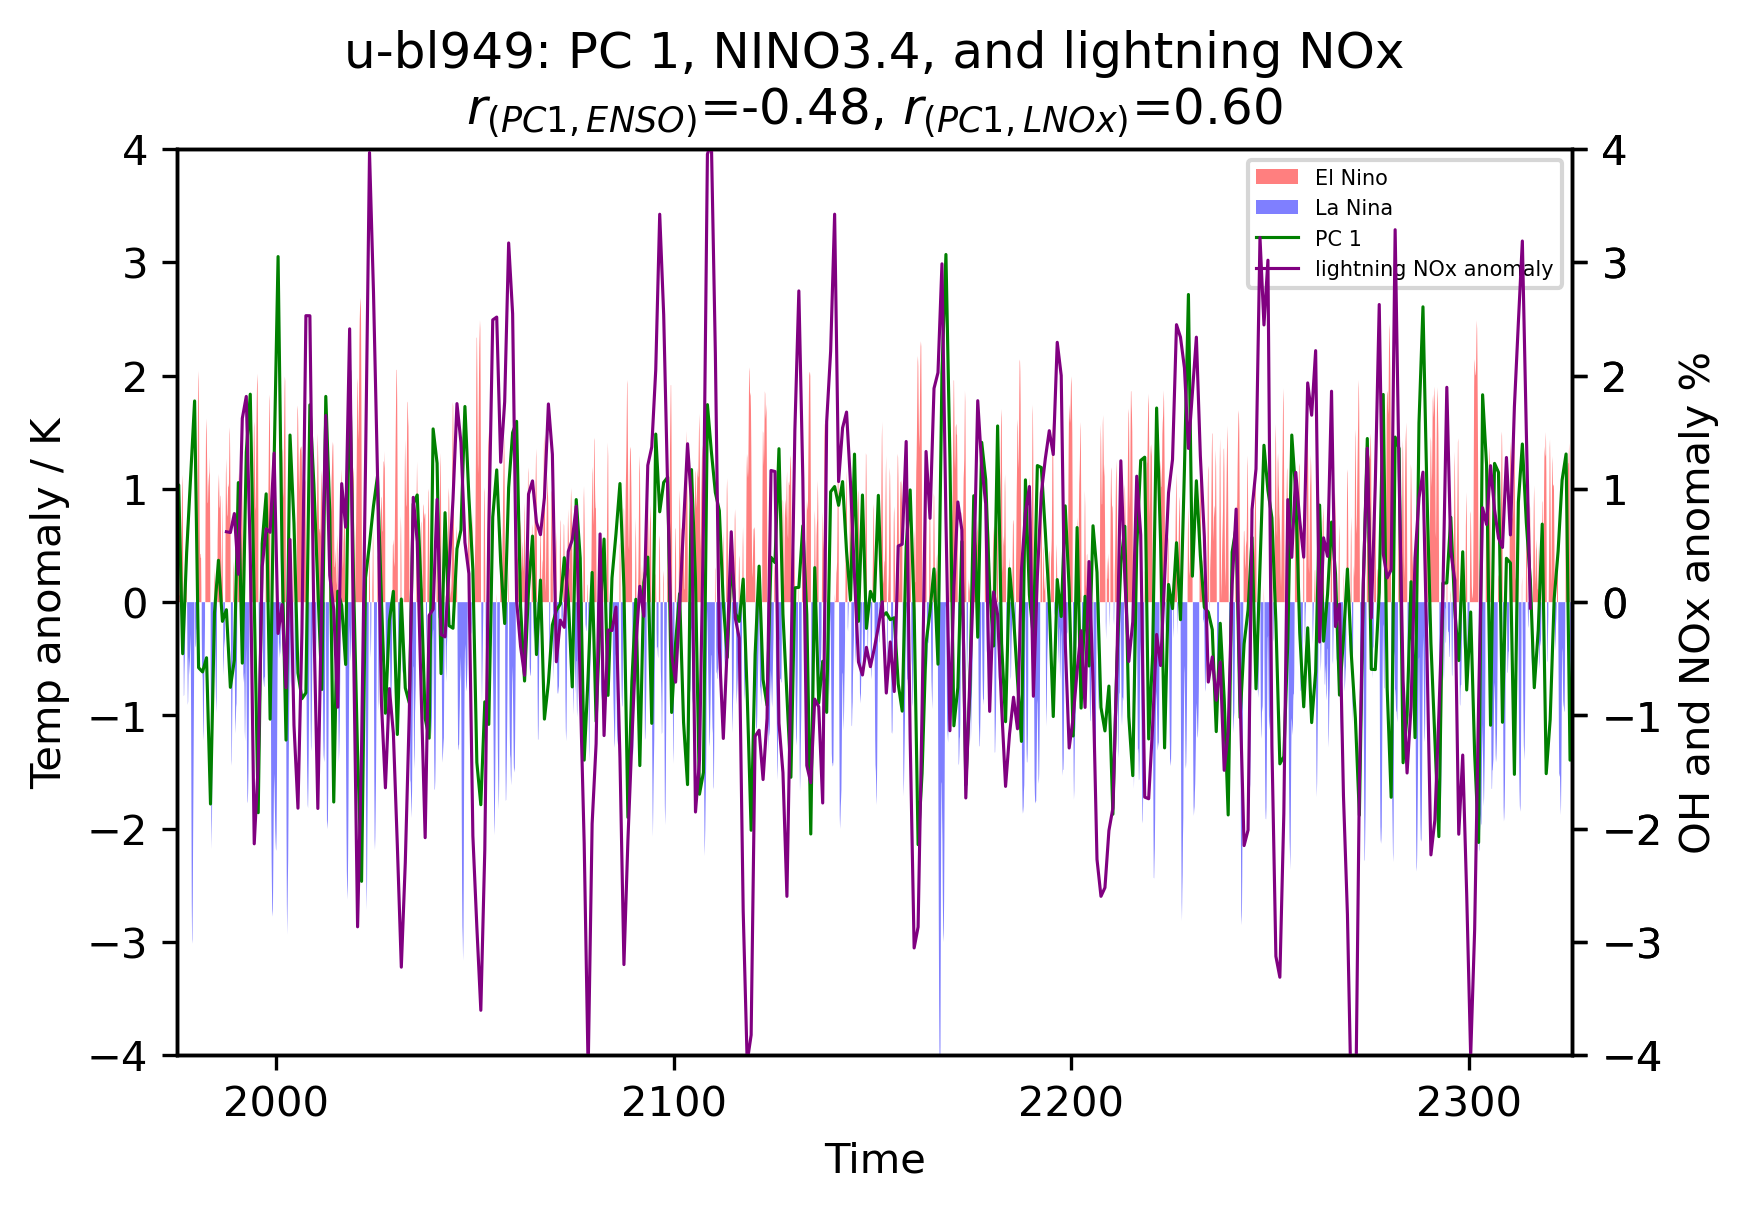

In [34]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
#p4, = ax.plot(time_949[:925], temp_anomaly_bl949, label = 'SST anomaly', c = 'k', linewidth = 0.1)
p1 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH and NOx anomaly %', fontsize=10)
p3, = ax1.plot(time,-pcs[:,0], c='green', linewidth = 0.75,label='PC 1')

ax2 = ax.twinx()
p4, = ax2.plot(ndtime[25:-25],percanomaly, c='purple', linewidth=0.75, label='lightning NOx anomaly')

ax.set_ylim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_ylim(-4,4)
ax.set_xlim(dtime_949[180],dtime_949[-180])

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3,p4],fontsize=5,loc ='upper right')
ax.set_xlabel('Time')

plt.title('u-bl949: PC 1, NINO3.4, and lightning NOx' '\n' '$r_{(PC1,ENSO)}$=-0.48, $r_{(PC1,LNOx)}$=0.60')

In [37]:
pearsonr(percanomaly,-pcs[50:-50
    ,0])

(0.027351630996921387, 0.6210816772771317)